In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin
/kaggle/input/smalldata/lwd.csv
/kaggle/input/smalldata/feelingdepressed.csv
/kaggle/input/smalldata/songs.csv
/kaggle/input/testing/normal1.csv


In [17]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
import re
nltk.download('words')
from gensim.models import KeyedVectors
from bs4 import BeautifulSoup


[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [4]:
train_data = pd.read_csv('/kaggle/input/smalldata/lwd.csv')
train_data.columns

Index(['ID', 'Author Name', 'Author Channel URL', 'Public', 'Published',
       'Comment', 'Unnamed: 6'],
      dtype='object')

In [5]:
train_data = train_data.drop(columns=['ID', 'Author Name', 'Author Channel URL', 'Public', 'Published'])
train_data.head()

,Comment,Unnamed: 6
0,My new video - THIS IS DEPRESSION (VERY WELL: ...,0.0
1,I am fucking done with this life 😫😫 what shoul...,1.0
2,“My life is full of problems. When one problem...,1.0
3,Yiu just have to believe that you worth someth...,0.0
4,If you’re depressed and you know it clap your ...,1.0


In [6]:
train_data = train_data.rename(columns={'Unnamed: 6':'Label'})
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Comment  100 non-null    object 
 1   Label    98 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [7]:
#filling missing values with 1.0
fillers = [1.0, 1.0]
train_data.loc[train_data.Label.isnull(), 'Label'] = fillers
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Comment  100 non-null    object 
 1   Label    100 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [8]:
train_data['Label'] = train_data['Label'].map({1.0:'Depressed', 0.0: 'Not Depressed'})
train_data.head()

,Comment,Label
0,My new video - THIS IS DEPRESSION (VERY WELL: ...,Not Depressed
1,I am fucking done with this life 😫😫 what shoul...,Depressed
2,“My life is full of problems. When one problem...,Depressed
3,Yiu just have to believe that you worth someth...,Not Depressed
4,If you’re depressed and you know it clap your ...,Depressed


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  100 non-null    object
 1   Label    100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


In [12]:
train_data.Comment.head()

0    My new video - THIS IS DEPRESSION (VERY WELL: ...
1    I am fucking done with this life 😫😫 what shoul...
2    “My life is full of problems. When one problem...
3    Yiu just have to believe that you worth someth...
4    If you’re depressed and you know it clap your ...
Name: Comment, dtype: object

In [67]:
#removing non english text
words = set(nltk.corpus.words.words())
train_data['englishcomments'] = train_data['Comment'].apply (lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))
train_data.head()

,Comment,Label,englishcomments,cleanedcomments
0,My new video - THIS IS DEPRESSION (VERY WELL: ...,Not Depressed,My new video - THIS IS DEPRESSION ( VERY WELL ...,new video depression well episode 1 new mental...
1,I am fucking done with this life 😫😫 what shoul...,Depressed,I am done with this life 😫😫 what should I do,done life
2,“My life is full of problems. When one problem...,Depressed,"“ My life is full of . When one problem is , a...",life full one problem another arise
3,Yiu just have to believe that you worth someth...,Not Depressed,just have to believe that you worth something ...,believe worth something somehow mean world
4,If you’re depressed and you know it clap your ...,Depressed,If you ’ re depressed and you know it clap you...,depressed know clap depressed know clap depres...


In [14]:
train_data['englishcomments'] = train_data['englishcomments'].str.lower()
train_data.head()

,Comment,Label,englishcomments
0,My new video - THIS IS DEPRESSION (VERY WELL: ...,Not Depressed,my new video - this is depression ( very well ...
1,I am fucking done with this life 😫😫 what shoul...,Depressed,i am done with this life 😫😫 what should i do
2,“My life is full of problems. When one problem...,Depressed,"“ my life is full of . when one problem is , a..."
3,Yiu just have to believe that you worth someth...,Not Depressed,just have to believe that you worth something ...
4,If you’re depressed and you know it clap your ...,Depressed,if you ’ re depressed and you know it clap you...


In [15]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13395 entries, 0 to 11824
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  13395 non-null  object
dtypes: object(1)
memory usage: 209.3+ KB


In [68]:
#DATA CLEANING
space_replace = re.compile('[/(){}\[\]\|@,;]')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = nltk.corpus.stopwords.words('english')
extensions = ['rt', 'RT']
stopwords.extend(extensions)
urls = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+' 'rt')

def text_cleaning(text):
    text = BeautifulSoup(text, "lxml").text #removing any html decoding
    text = text.lower() #removing capitalization
    text = space_replace.sub(' ', text)#replacing symbols with a space
    text = bad_symbols.sub('', text) #deleting symbols from the text
    text = ' '.join(word for word in text.split() if word not in stopwords) #removing stopwords
    text = urls.sub('', text)#removing urls
    return text
train_data['cleanedcomments'] = train_data['englishcomments'].apply(text_cleaning)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:312: UserWarning: ".." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % self._decode_markup(markup)


In [19]:
train_data.head()

,Comment,Label,englishcomments,cleanedcomments
0,My new video - THIS IS DEPRESSION (VERY WELL: ...,Not Depressed,my new video - this is depression ( very well ...,new video depression well episode 1 new mental...
1,I am fucking done with this life 😫😫 what shoul...,Depressed,i am done with this life 😫😫 what should i do,done life
2,“My life is full of problems. When one problem...,Depressed,"“ my life is full of . when one problem is , a...",life full one problem another arise
3,Yiu just have to believe that you worth someth...,Not Depressed,just have to believe that you worth something ...,believe worth something somehow mean world
4,If you’re depressed and you know it clap your ...,Depressed,if you ’ re depressed and you know it clap you...,depressed know clap depressed know clap depres...


In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Comment          100 non-null    object
 1   Label            100 non-null    object
 2   englishcomments  100 non-null    object
 3   cleanedcomments  100 non-null    object
dtypes: object(4)
memory usage: 3.2+ KB


In [21]:
import logging
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

In [24]:
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin', binary=True)
word_vectors.init_sims(replace=True)

In [27]:
#FEATURE ENGINEERING
#word averaging
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [28]:
train_data['cleanedcomments'] = train_data['cleanedcomments'].astype(str)


In [30]:
train_data_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['cleanedcomments']), axis=1).values
train_data_averaged = word_averaging_list(word_vectors, train_data_tokenized)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  # Remove the CWD from sys.path while we load stuff.


In [32]:
#we introduce penalties to address overfitting due to the small training set being used
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty = 'l2', C=0.1)
model.fit(train_data_averaged, train_data['Label'])




LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
test_data = pd.read_csv("/kaggle/input/testing/normal1.csv")
test_data.head()

,Time,Text,Unnamed: 2,Unnamed: 3
0,2020-05-09 17:53:51,"RT @SingleCare: For #MentalHealthMonth, we're ...",NaN,NaN
1,2020-05-09 17:49:25,"In the mood for a sweet😍, sexy🔥 #mmromance #no...",NaN,NaN
2,2020-05-09 17:47:09,I have been off my mostly vegetarian diet sinc...,NaN,NaN
3,2020-05-09 17:44:47,"RT @SingleCare: For #MentalHealthMonth, we're ...",NaN,NaN
4,2020-05-09 17:44:26,"RT @SingleCare: For #MentalHealthMonth, we're ...",NaN,NaN


In [35]:
test_data.columns

Index(['Time', 'Text', 'Unnamed: 2', 'Unnamed: 3'], dtype='object')

In [36]:
test_data = test_data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Time'])
test_data.head()

,Text
0,"RT @SingleCare: For #MentalHealthMonth, we're ..."
1,"In the mood for a sweet😍, sexy🔥 #mmromance #no..."
2,I have been off my mostly vegetarian diet sinc...
3,"RT @SingleCare: For #MentalHealthMonth, we're ..."
4,"RT @SingleCare: For #MentalHealthMonth, we're ..."


In [37]:
test_data['newtext'] = test_data['Text'].apply(text_cleaning)
test_data.head()

,Text,newtext
0,"RT @SingleCare: For #MentalHealthMonth, we're ...",singlecare #mentalhealthmonth hosting #giveawa...
1,"In the mood for a sweet😍, sexy🔥 #mmromance #no...",mood sweet sexy #mmromance #novella grumpy #ch...
2,I have been off my mostly vegetarian diet sinc...,mostly vegetarian diet since quarantine starte...
3,"RT @SingleCare: For #MentalHealthMonth, we're ...",singlecare #mentalhealthmonth hosting #giveawa...
4,"RT @SingleCare: For #MentalHealthMonth, we're ...",singlecare #mentalhealthmonth hosting #giveawa...


In [38]:
test_data['newtext'] = test_data['newtext'].astype(str)
test_data_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['newtext']), axis=1).values
test_data_averaged = word_averaging_list(word_vectors, test_data_tokenized)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  # Remove the CWD from sys.path while we load stuff.


In [39]:
predictions = model.predict(test_data_averaged)
test_data.Labels = predictions
test_data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


,Text,newtext
0,"RT @SingleCare: For #MentalHealthMonth, we're ...",singlecare #mentalhealthmonth hosting #giveawa...
1,"In the mood for a sweet😍, sexy🔥 #mmromance #no...",mood sweet sexy #mmromance #novella grumpy #ch...
2,I have been off my mostly vegetarian diet sinc...,mostly vegetarian diet since quarantine starte...
3,"RT @SingleCare: For #MentalHealthMonth, we're ...",singlecare #mentalhealthmonth hosting #giveawa...
4,"RT @SingleCare: For #MentalHealthMonth, we're ...",singlecare #mentalhealthmonth hosting #giveawa...


In [40]:
model.predict_proba(test_data_averaged)[:,1]

array([0.32056382, 0.35970397, 0.33373454, ..., 0.32806312, 0.32088899,
       0.33915917])

In [44]:
results = model.predict(test_data_averaged)

In [45]:
test_data['Label'] = results
test_data.head()

,Text,newtext,Label
0,"RT @SingleCare: For #MentalHealthMonth, we're ...",singlecare #mentalhealthmonth hosting #giveawa...,Depressed
1,"In the mood for a sweet😍, sexy🔥 #mmromance #no...",mood sweet sexy #mmromance #novella grumpy #ch...,Depressed
2,I have been off my mostly vegetarian diet sinc...,mostly vegetarian diet since quarantine starte...,Depressed
3,"RT @SingleCare: For #MentalHealthMonth, we're ...",singlecare #mentalhealthmonth hosting #giveawa...,Depressed
4,"RT @SingleCare: For #MentalHealthMonth, we're ...",singlecare #mentalhealthmonth hosting #giveawa...,Depressed


In [46]:
test_data.Label.unique()

array(['Depressed'], dtype=object)

In [49]:
from xgboost import XGBClassifier

model2 = XGBClassifier(
    max_depth=2,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5
)
model2.fit(train_data_averaged, train_data['Label'])
predictions = model2.predict(test_data_averaged)


In [50]:
predictions

array(['Depressed', 'Depressed', 'Depressed', ..., 'Not Depressed',
       'Depressed', 'Depressed'], dtype=object)

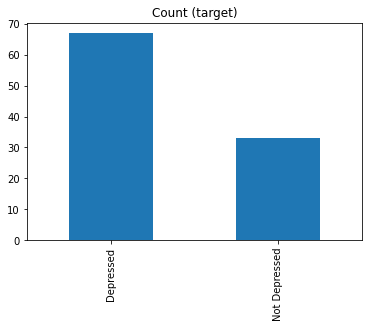

In [51]:
train_data['Label'].value_counts().plot(kind='bar', title='Count (target)');

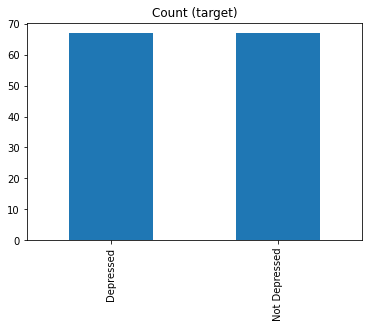

In [59]:
# oversampling the minority class
from imblearn.over_sampling import SMOTE

smote = SMOTE(n_jobs=-1)
X_sm, y_sm = smote.fit_resample(train_data_averaged, train_data['Label'])

new_data = pd.DataFrame(X_sm)
new_data['target'] = y_sm

new_data['target'].value_counts().plot(kind='bar', title='Count (target)');

In [60]:
new_data.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,target
0,-0.045203,0.019931,-0.025141,0.068327,-0.064588,0.058710,-0.006737,-0.053131,0.051569,0.020215,...,0.018140,-0.100826,-0.031508,-0.074614,0.010880,-0.001024,-0.002776,0.006268,-0.013800,Not Depressed
1,-0.033888,0.097610,0.000879,0.061121,0.010142,-0.026011,0.047275,-0.017769,0.110846,-0.001480,...,0.012055,-0.161448,0.025510,-0.142513,0.101179,0.075350,0.024672,-0.029413,-0.038313,Depressed
2,0.063947,-0.022128,0.000862,0.137984,-0.045269,0.008077,0.105089,-0.029343,0.059006,0.069043,...,0.023778,-0.101798,-0.040240,-0.090855,0.065516,-0.049198,-0.019636,-0.004439,-0.058134,Depressed
3,0.027145,-0.010727,0.056899,0.094702,-0.080164,0.053827,0.108491,-0.057509,0.070042,0.056908,...,0.076939,-0.020395,0.039342,-0.040548,-0.063985,-0.011903,-0.010606,0.070849,-0.053130,Not Depressed
4,0.016269,-0.033170,-0.042689,0.069413,-0.132550,0.004943,0.067192,-0.016154,0.087384,0.046552,...,0.053863,-0.067370,-0.031807,-0.028627,-0.050967,-0.013821,-0.009823,0.080007,-0.040922,Depressed


In [64]:
features = new_data.drop(columns=['target'])
label = new_data['target']
model.fit(features, label)
new_predictions = model.predict(test_data_averaged)
test_data['ultranewpredictions'] = new_predictions
test_data.head()

,Text,newtext,Label,ultranewpredictions
0,"RT @SingleCare: For #MentalHealthMonth, we're ...",singlecare #mentalhealthmonth hosting #giveawa...,Depressed,Depressed
1,"In the mood for a sweet😍, sexy🔥 #mmromance #no...",mood sweet sexy #mmromance #novella grumpy #ch...,Depressed,Not Depressed
2,I have been off my mostly vegetarian diet sinc...,mostly vegetarian diet since quarantine starte...,Depressed,Depressed
3,"RT @SingleCare: For #MentalHealthMonth, we're ...",singlecare #mentalhealthmonth hosting #giveawa...,Depressed,Depressed
4,"RT @SingleCare: For #MentalHealthMonth, we're ...",singlecare #mentalhealthmonth hosting #giveawa...,Depressed,Depressed


In [66]:
import pickle
filename = 'testfile.sav'
pickle.dump(model, open(filename, 'wb'))